In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='paper',fscale=0.6, spines=True, gridlines='--',ticks=True, grid=True) #onedork

import SimpleITK as sitk
import numpy as np
import os 
import time 
import psutil
import multiprocessing

from scipy.interpolate import splev, splrep
from scipy.ndimage.filters import gaussian_filter, gaussian_filter1d
from skimage.measure import block_reduce

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from pwi_funcs import *

### Motion Correction (Registration）
1. spm
2. sitk
3. sitk SimpleElastix

### Define Params

In [2]:
# SVD parameters
PRE = 5
POST = 60 
loth = 0   #low threshold
hith = 250 # high threshold
rho = 1.04 # average brain tissue density, unit: mL/g

# filtering params
sigma_t = 1
sigma_s = 0.1

# choose sample slice to plot
slice_i = 14
scan_i = 30 

tith = 6 # Tmax threshold for penumbra

### Extract data (from mullti dicom dir to interpolated 4d.nii)

we have 1 series here. 
time interval: 1.47 
 number of slices:  21 
 original arr shape is: (1260, 128, 128)
Downsampled shape is  (1260, 64, 64)
(60, 21, 64, 64)
2.425013 seconds
-27.00203154650751 1437.5000000000002
Done, converting result to array...
It takes 2.65s to interpolate.
After interpolation arr shape is:  (88, 21, 64, 64)
Echo Time is  0.03


/home/drbrainer/yupei/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/home/drbrainer/yupei/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log


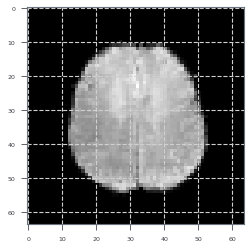

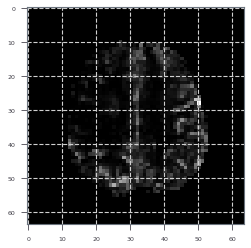

../../data/PWIDWI/PWI/output/13/1.3.12.2.1107.5.2.20.156081.2019110410301277980952133.0.0.0.nii created! 



In [3]:
%matplotlib inline

all_start = time.time()

data_path = '../../data/PWIDWI/PWI/new'
out_dir = '../../data/PWIDWI/PWI/output'
mask_dir = '../../data/PWIDWI/PWI/mask'

dsample_factor = (1, 2, 2)

study_dir_list = os.listdir(data_path)
for study in study_dir_list:
    study_path = os.path.join(data_path, study)
    series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(study_path)
    print('we have %d series here. '%len(series_ids))
    
    for series_id in series_ids:
        arr, dt, n_slices, tags = read_dcm(study_path, series_id)
        print('time interval:',dt, '\n number of slices: ', n_slices,'\n original arr shape is:', arr.shape)

        # Downsample
        arr = block_reduce(arr, block_size=dsample_factor, func=np.mean)
        print('Downsampled shape is ', arr.shape)
        
        # Define bone mask for skull stripping
        mask_dir = os.path.join(mask_dir, study)
        if not os.path.exists(mask_dir):
            os.mkdir(mask_dir) 
        mask_path = mask_dir+'/first_brain.nii'  # mask location generated with bat
        mask = sitk.ReadImage(mask_path)
        mask = sitk.GetArrayFromImage(mask)
        mask = block_reduce(mask, block_size=dsample_factor, func=np.mean)
        mask[mask<0] = 0
        mask[mask>0] = 1
        
        # Time correction
        time_start = time.time()
        arr_interp = interpolation(arr, mask, dt, n_slices)
        print('It takes %.2fs to interpolate.'%(time.time()-time_start))
        print('After interpolation arr shape is: ', arr_interp.shape)
        mask= np.array([mask]*arr_interp.shape[0])
        
        # MR value convert
        base = np.zeros((arr_interp.shape[1], arr_interp.shape[2], arr_interp.shape[3]))
        base = np.mean(arr_interp[0:PRE,:,:,:],axis=0)
        TE = float(tags[3]) * 1e-3# eg. unit ms (需读取tag)  #'0018,0081' Echo Time
        print('Echo Time is ',TE)
        
        for t in range(arr_interp.shape[0]):
            St = arr_interp[t, :, :, :]
#             temp=div0(St, base)
            temp = np.true_divide(St, base+1e-20)     # 填离职表格
            St = -(1/TE)*np.log(temp)
            arr_interp[t, :, :, :] = St
        arr_interp[arr_interp == np.inf] = 0
        arr_interp=np.nan_to_num(arr_interp)       
        
        # Check results with one sample slice
        plt.figure()
        plt.imshow(base[slice_i,:,:], cmap='gray')
        plt.show()
        
        plt.figure()
        arr_clip = np.clip(arr_interp, loth, math.inf) # optinal 
        plt.imshow(arr_clip[scan_i,slice_i,:,:], cmap='gray')
        plt.show()      
        
        # Output 
        img_interp = sitk.GetImageFromArray(arr_interp)
        img_interp.SetOrigin(tags[0])
        img_interp.SetSpacing(tags[1])
        img_interp.SetDirection(tags[2])
        
        output_dir = os.path.join(out_dir, study)
        if not os.path.exists(output_dir):
            os.mkdir(output_dir) 
        
        sitk.WriteImage(img_interp, os.path.join(output_dir,series_id+'.nii'))
        print('{} created! \n'.format(os.path.join(output_dir, series_id+'.nii')))
        del arr, arr_interp

### Filtering in time and spatial domain

1.3.12.2.1107.5.2.20.156081.2019110410301277980952133.0.0.0.nii


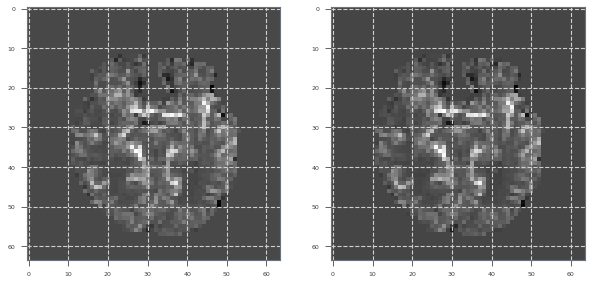

max and min is  73.54 -57.52
内存使用： 806330368
总内存： 16698171392
Memory usage：21.3%
cpu个数： 4


In [4]:
%matplotlib inline

files = os.listdir(output_dir)
for file in files:
    if os.path.splitext(file)[1]=='.nii':
        print(file)
        img = sitk.ReadImage(os.path.join(output_dir, file))
        arr_interp = sitk.GetArrayFromImage(img)

        arr = np.copy(arr_interp)
        [nt,nz,nx,ny] = arr.shape

        # time filtering
        arr = gaussian_filter1d(arr, sigma_t, axis=0)

#         # 2d spatial filtering
#         for t in range(nt):
#             for z in range(nz):
#                 arr[t,z,:,:] = gaussian_filter(arr[t,z,:,:], sigma_s) 

        # get mask
#         mask = get_mask_old(base, loth, hith)
#         mask = get_mask(base, loth, hith)
#         mask = np.array([mask]*nt)        

        # segmentation: set non-interested region to 0 or minimum intensity
        #arr = arr*mask
#         print('Segmenting...')
#         arr[np.where(mask==0)]=np.min(arr)

        # Check results with one sample slice
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow(arr_interp[30,8,:,:], cmap='gray')
        ax[1].imshow(arr[30,8,:,:], cmap='gray')
        plt.show()
        plt.close()
        
        print('max and min is ', round(np.max(arr), 2), round(np.min(arr), 2))
        
        print_mem()
        
        C = arr
        
        del arr

### AIF & VOF Selection

In [5]:
# # manual selection

# import matplotlib.pyplot as plt
# # %matplotlib qt5
# n=int(input("Which slice?"))
# #im = (np.sum(C, axis=0)*mask[0])[n,:,:]
# im = arr[0,n,:,:]
# plt.figure(figsize=(12, 12))
# plt.imshow(np.clip(im,0,100), cmap = plt.get_cmap("gray"))
# pos=plt.ginput(20)
# print(pos)
# plt.close()
# %matplotlib inline
# for p in pos:
#     plt.plot(arr[:,n,int(p[0]),int(p[1])]- np.mean(arr[0:5,n,int(p[0]),int(p[1])]))
# plt.show()



Searching for candidate voxel,...
0.759013 seconds
<generator object <genexpr> at 0x7f60fb44c360>
Converting result to array...done
636 candidates found


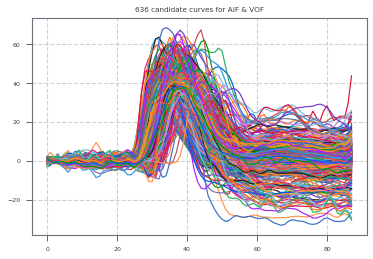

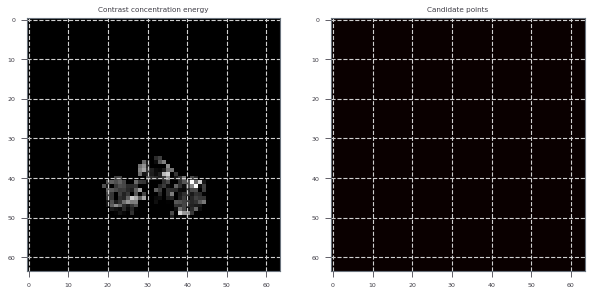

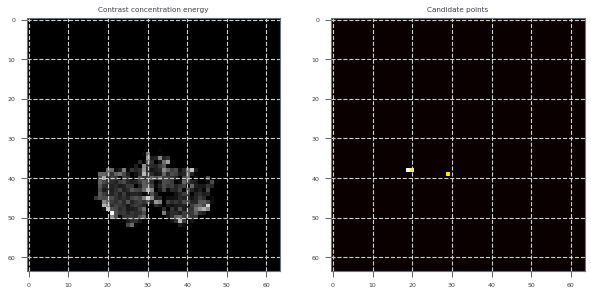

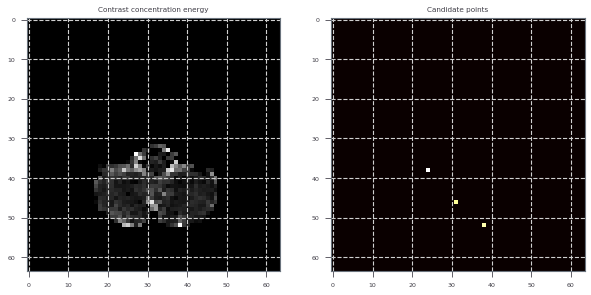

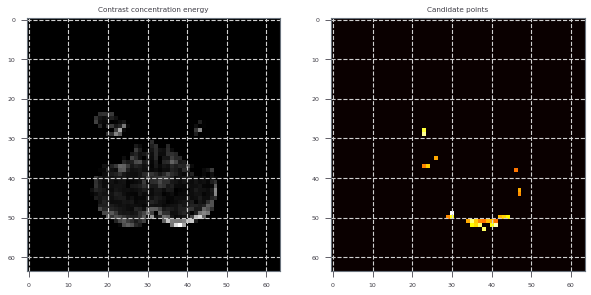

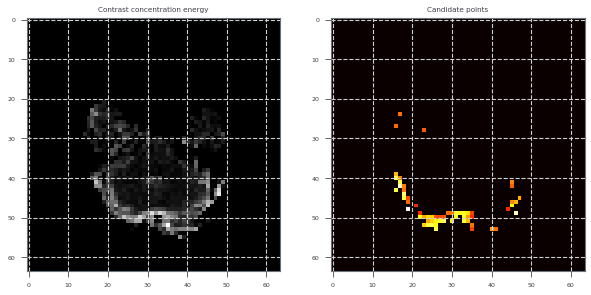

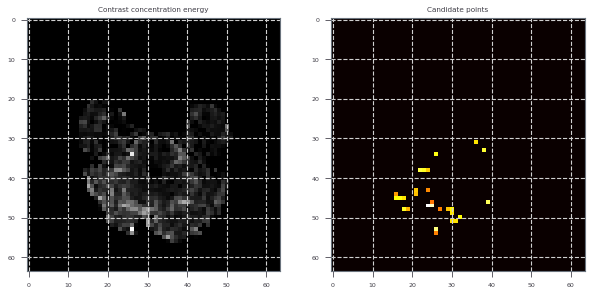

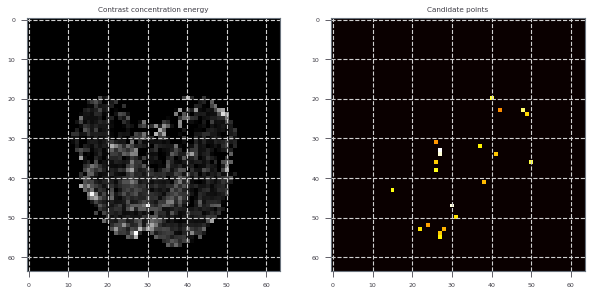

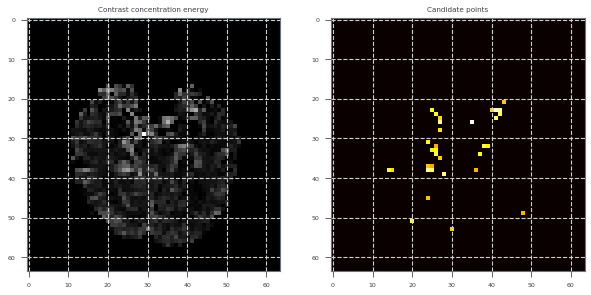

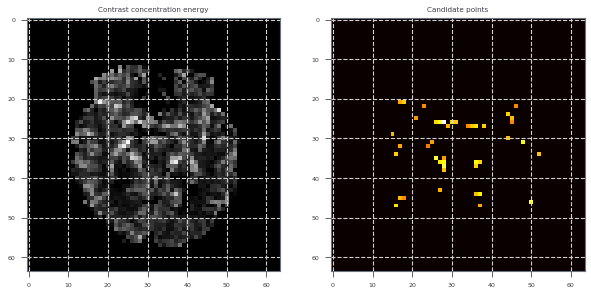

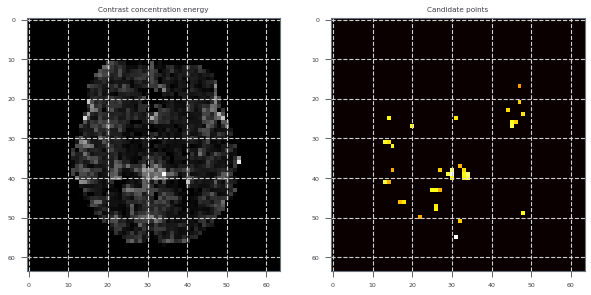

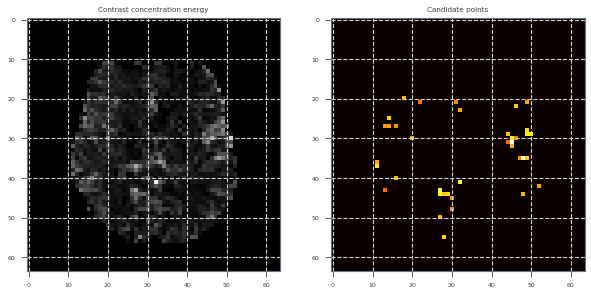

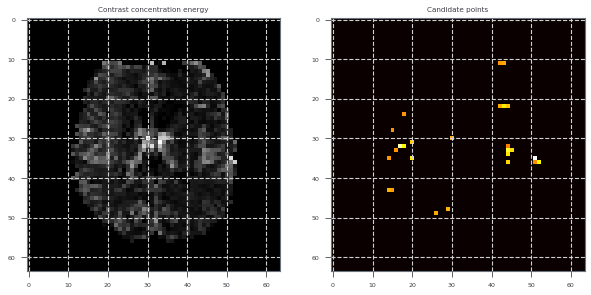

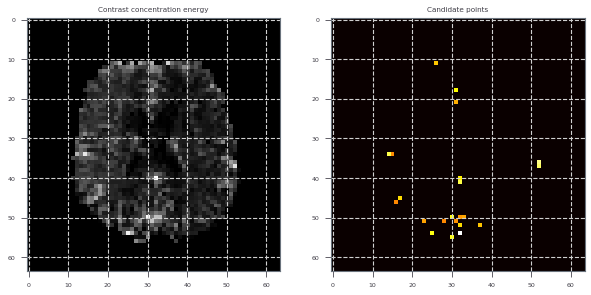

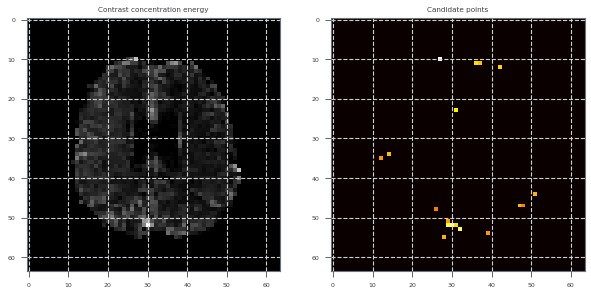

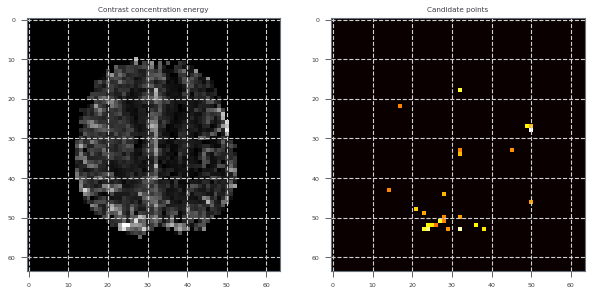

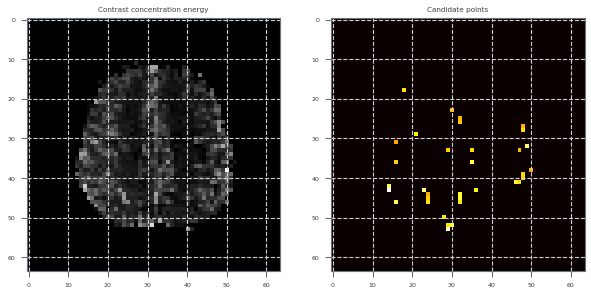

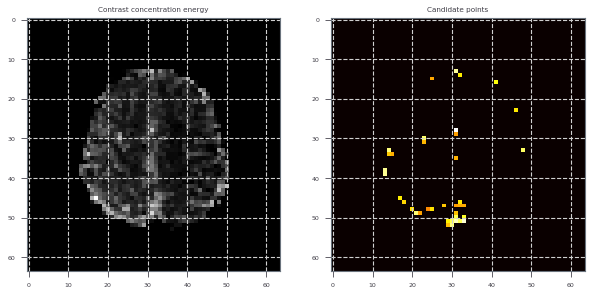

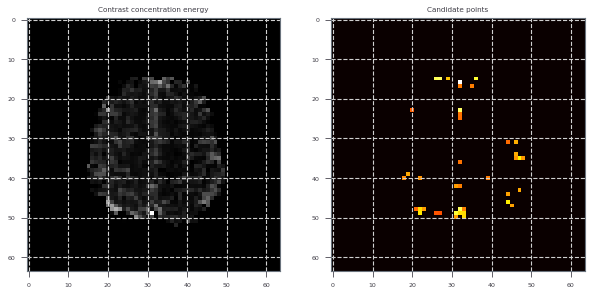

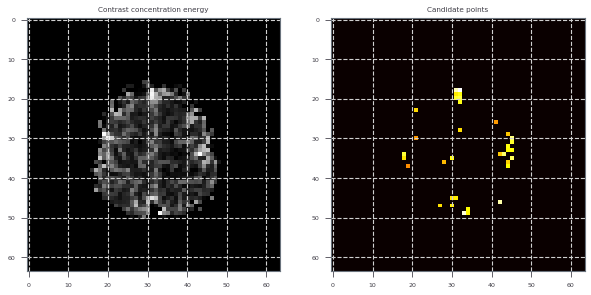

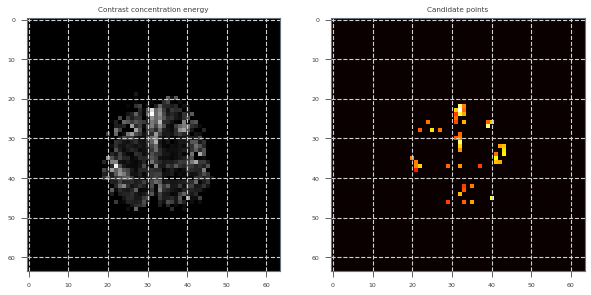

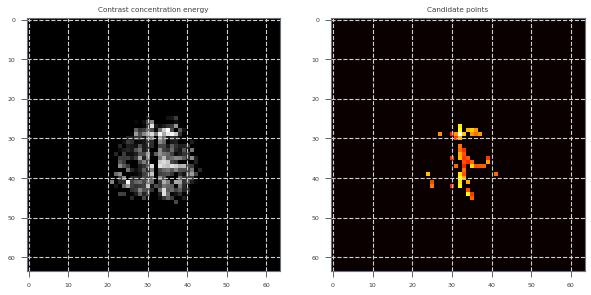

In [6]:
################################# AIF & VOF selection #################################

kernel = gausskernel(5)
print('\nSearching for candidate voxel,...')
# print(np.max(C))
args = [ ( C[:,z,x,y], mask[0,z,x,y], kernel ) for z in range(nz) for x in range(nx) for y in range(ny)]
tchanges = multi_proc(total_change, args, 10)

print(lambda x: x!=0 for x in tchanges)
print("Converting result to array...", end="")
tchanges = np.array(tchanges).reshape(nz,nx,ny)#.astype(np.int16)
print("done")

th1 = np.max(tchanges)*0.1
#mask_vs = np.array( [np.where(tchanges > th1, 1, 0) ]*nt, dtype=np.int16)
sigs = [ ( C[:,z,x,y], (z,x,y) ) for z in range(nz) for x in range(nx) for y in range(ny) if tchanges[z,x,y] > th1]
sigs, locs = zip(*sigs)

print(len(sigs), "candidates found")

plot_path = output_dir+'/plots/'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)
for x in sigs:
    plt.plot(x)
plt.title(str(len(sigs))+" candidate curves for AIF & VOF")
# plt.savefig(plot_path+str(len(sigs))+"_candidates.png")
plt.show()
plt.close()


#-------------------------- check candidate voxels' location -------------------------#

for n in range(nz):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    plt.title("Slice "+str(n+1))
    ax[0].set_title('Contrast concentration energy')
    ax[1].set_title('Candidate points')
    ax[0].imshow(np.clip((np.sum(C, axis=0)*mask[0]), loth, np.inf)[n,:,:], cmap='gray')
    ax[1].imshow(tchanges[n,:,:], cmap='hot')
#     plt.savefig(plot_path+"vess_"+str(n+1)+".png")
    plt.show()
    plt.close()


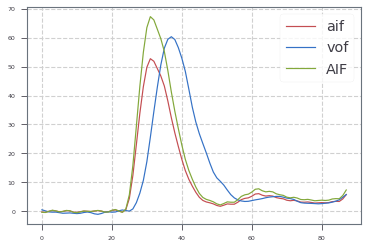

In [7]:
############################## separate AIF and VOFs ##################################
temp=np.amax(sigs,axis=0)
maxx = np.max(temp)*0.5
sigs = [x for x in sigs if np.max(x) > 0]
sigs= sorted(sigs, key=lambda x:np.argmax(x))

# separate AIFs
ea = np.argmax(sigs[0])
th = ea + 3
aifs = [x for x in sigs if np.argmax(x) < th]

fig, ax = plt.subplots(1,2, figsize=(12,4))
for aif in aifs:
    ax[0].plot(aif)
aifs = sorted(aifs, key=lambda x:np.max(x), reverse=True)

aif = np.mean(aifs[0:10], axis=0)
ax[1].plot(aif)
plt.savefig(plot_path+"aifs.png")
plt.close()

# separate VOFs
th = np.mean(np.argmax(aifs, axis = 1)) + 2
th1 = ea+12
vofs = [x for x in sigs if th < np.argmax(x) < th1]

fig, ax = plt.subplots(1,2, figsize=(12,4))
for vof in vofs:
    ax[0].plot(vof)
vofs = sorted(vofs, key=lambda x:np.max(x), reverse=True)

vof = np.mean(vofs[0:10], axis=0)
ax[1].plot(vof)
plt.savefig(plot_path+"vofs.png")
plt.close()

# scaling
AIF = (aif*(np.sum(vof)/np.sum(aif)))#.astype(np.int16)
p1, = plt.plot(aif, 'r', label='aif')
p2, = plt.plot(vof, 'b', label='vof')
p3, = plt.plot(AIF, 'g', label= 'AIF')

plt.legend([p1,p2,p3], ['aif', 'vof', 'AIF'], fontsize='x-large')

plt.savefig(plot_path+"AIF.png")
plt.show()
plt.close()


### Correctin for nonlinear effects of Gd tracer

In [8]:
# for certain location

# At 1.5T
x1=22.7
x2=7.6e-3
x3=574e-6

# #At 3.0T
# x1=11.5
# x2=0.493e-3
# x3=2.62e-3

Ct=x1*C
Ca=np.abs(-x2+np.sqrt(np.abs(x2**2+4*x3*AIF)))
# print(Ct.shape, Ca.shape)

### Computing perfusion maps

#### Computing Residual Funciton

In [9]:
lamb = 0.2

# Correction
AIF=Ca
C=Ct

# calculate residual function
print("Calculating residual functions...")
# print(AIF) 
invAIF = get_invAIF(AIF[PRE:POST], lamb)
args = [(invAIF, C[PRE:POST,z,x,y]) for z in range(nz) for x in range(nx) for y in range(ny)]
R = multi_proc(ctSVD, args, 10)

# convert result to array
print("Converting result to array...")
nt_trunc = len(R[0])
R = np.array(R).reshape(nz,nx,ny,nt_trunc)
R = np.moveaxis(R, -1, 0)
print('Done, shape:',R.shape, 'dtype:',R.dtype, 'max=', np.max(R), 'min=', np.min(R))
#sio.savemat(output_path+'/R.mat', mdict={'R':R, 'arr':arr, 'base':base, 'C': C, 'mask':mask})
print_mem()


Calculating residual functions...
55
2.082982 seconds
Converting result to array...
Done, shape: (55, 21, 64, 64) dtype: float64 max= 395.327044177635 min= -307.9496096662533
内存使用： 970862592
总内存： 16698171392
Memory usage：22.3%
cpu个数： 4


#### Computing feature maps & penumbra volume

Tmax max 43s and min: 0s


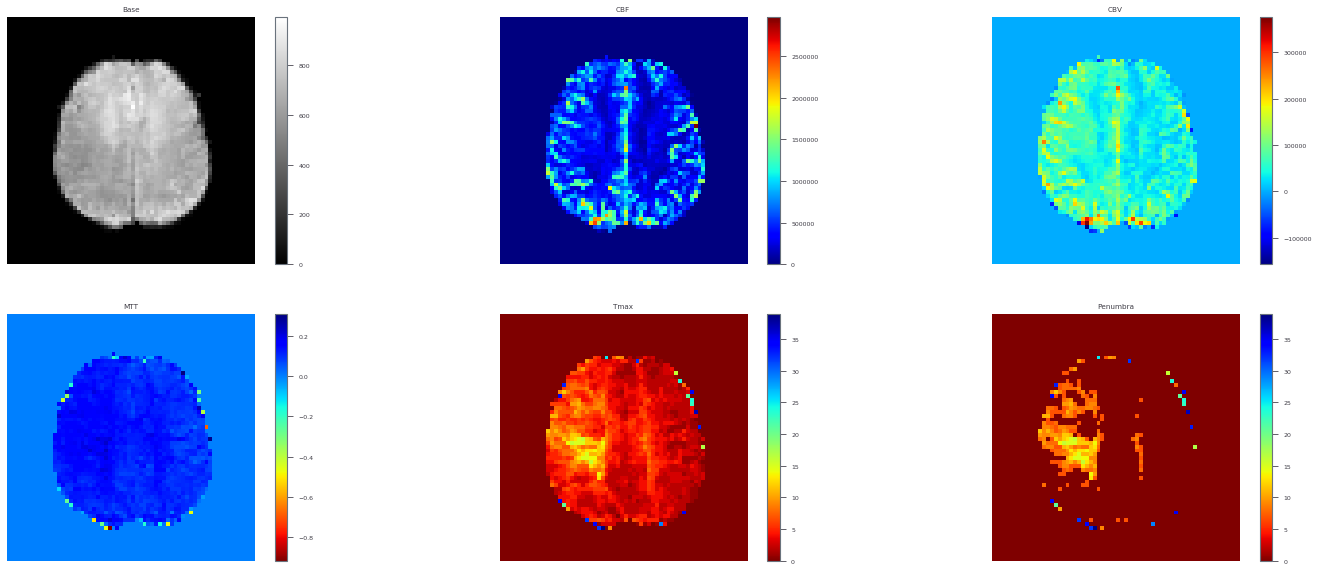

penumbra vol = 6808
Total cost of time 23.01 seconds 


In [10]:
khema = (1-0.25)/(1-0.45)

CBF = 60*100*khema*np.amax(R, axis = 0)/rho
CBV = 100*khema*np.sum(R, axis = 0)/rho
MTT = CBV/(CBF+1e-20)
Tmax = np.argmax(R, axis = 0)
print('Tmax max {}s and min: {}s'.format(np.max(Tmax), np.min(Tmax)))

# save output
output_dir = os.path.join(output_dir, 'FeatureMaps')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
img = sitk.GetImageFromArray(CBF)
sitk.WriteImage(img, os.path.join(output_dir, 'CBF.nii'))
img = sitk.GetImageFromArray(CBV)
sitk.WriteImage(img, os.path.join(output_dir, 'CBV.nii'))
img = sitk.GetImageFromArray(MTT)
sitk.WriteImage(img, os.path.join(output_dir, 'MTT.nii'))
img = sitk.GetImageFromArray(Tmax)
sitk.WriteImage(img, os.path.join(output_dir, 'Tmax.nii'))

# penumbra
penumbra = np.where(Tmax>tith, Tmax, 0)

# plot feature maps and penumbra
plot_maps(base, slice_i, plot_path, CBF, CBV, MTT, Tmax, penumbra)

# calculate penumbra volume 
voxel_size = 2
penumbra_vol = np.sum(penumbra>0)*voxel_size
print('penumbra vol =', penumbra_vol)

# Total cost of time
t_total = time.time()-all_start
print('Total cost of time %.2f seconds '% t_total)

# del arr, arr_interp, R, CBF, CBV, MTT, Tmax, penumbra

## Problems remained:
1. filtering in time and spatial domain (choice of sigma is significant)
2. contour in penumbra remained
3. spm registration interface (is it necessary to register)
4. fsl bet skull stripping interface